# ADA Project : Milestone 2

## Preparation

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from utils import *
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import geopandas as gpd
import contextily as ctx
import plotly.express as px
import pycountry

### Conversion : txt to csv
The reviews are written in a txt file. The reviews are separated by an empty line. Each review is structured with a list of field and content:

    field_1: content_1
    field_2: content_2
    ...
    field_n: content_n

The conversion translate this structures from text files to csv files that can be loaded as pandas dataframes

In [ ]:
# Require extensive amount of RAM (a bit less than 32Gb)
do_conversion = False
if do_conversion:
    ratings_text_to_csv("./data/BeerAdvocate/ratings.txt")
    ratings_text_to_csv("./data/RateBeer/ratings.txt")

### Load data

In [ ]:
# BeerAdvocate (BA)
beers_BA, breweries_BA, users_BA, ratings_BA = load_data("BA")

In [ ]:
# RateBeer (RB)
beers_RB, breweries_RB, users_RB, ratings_RB = load_data("RB")

In [ ]:
# Matched Dataset (MD) Not used yet
beers_MD, breweries_MD, users_MD, users_approx_MD, ratings_MD = load_data("MD")

### Describe dataframes content for BeerAdvocate and RateBeer
The description of the dataframes may be lacking details. The datasets are not documentated therefore some fields are somehow difficult to interpret/understand. Those uncertain fields are dropped, we don't want to work with data we do not understand

##### Beers

| Field (Clear)                  | Description                                       | Dataset |
|--------------------------------|---------------------------------------------------|---------|
| beer_id                        | Unique integer key for beer                       |  BOTH   |
| beer_name                      | Name of the beer                                  |  BOTH   |
| brewery_id                     | Unique integer key for brewery                    |  BOTH   |
| brewery_name                   | Name of the brewery                               |  BOTH   |
| style                          | Type of beer                                      |  BOTH   |
| nbr_ratings                    | Number of ratings about the beer                  |  BOTH   |
| nbr_reviews                    | Number of reviews about the beer                  |   BA    |
| abv                            | Alcohol by volume in percentile                   |  BOTH   |
| **Field (Unclear)**            | **Hypothesis**                                    |  **-**  |
| avg                            | avg overall-score across rating ?                 |  BOTH   |
| avg_computed                   | avg overall-score across rating ?                 |  BOTH   |
| ba_score                       | We don't know how it's computed                   |  BA     |
| bros_score                     | We don't know how it's computed                   |  BA     |
| overall_score                  | We don't know how it's computed                   |  RB     |
| style_score                    | We don't know how it's computed                   |  RB     |
| zscore                         | We don't know how it's computed                   |  BOTH   |
| nbr_matched_valid_ratings      | Related to matched dataset                        |  BOTH   |
| avg_matched_valid_ratings      | Related to matched dataset                        |  BOTH   |

##### Breweries

| Field (Clear)                  | Description                                       | Dataset |
|--------------------------------|---------------------------------------------------|---------|
| id                             | Unique integer key for brewery                    |  BOTH   |
| location                       | Country (+ State) of the brewery                  |  BOTH   |
| name                           | Name of the brewery                               |  BOTH   |
| nbr_beers                      | Number of different beers the brewery produces    |  BOTH   |

##### Users

| Field (Clear)                  | Description                                       | Dataset |
|--------------------------------|---------------------------------------------------|---------|
| user_id                        | Unique integer key corresponding to a user        |  BOTH   |
| user_name                      | Pseudonym of the user                             |  BOTH   |
| location                       | Location of the user (country or country+state)   |  BOTH   |
| nbr_ratings                    | Number of ratings made by the user                |  BOTH   |
| nbr_reviews                    | Number of reviews written by the user             |  BA     |
| **Field (Unclear)**            | **Hypothesis**                                    |  **-**  |
| joined                         | Related to matched dataset                        |  BOTH   |

##### Ratings

| Field (Clear)                  | Description                                       | Dataset |
|--------------------------------|---------------------------------------------------|---------|
| beer_name                      | Name of the beer                                  |  BOTH   |
| beer_id                        | Unique integer key corresponding to a beer        |  BOTH   |
| brewery_name                   | Name of the brewery                               |  BOTH   |
| brewery_id                     | Unique integer key corresponding to a brewery     |  BOTH   |
| user_id                        | Unique integer key corresponding to a user        |  BOTH   |
| user_name                      | Pseudonym of the user                             |  BOTH   |
| style                          | Style of the beer                                 |  BOTH   |
| abv                            | Alcohol by volume in percentile                   |  BOTH   |
| date                           | Timestamp of the review in seconds                |  BOTH   |
| appearance                     | Appearance score by the user                      |  BOTH   |
| aroma                          | Aroma score by the user                           |  BOTH   |
| palate                         | Palate score by the user                          |  BOTH   |
| taste                          | Taste score by the user                           |  BOTH   |
| overall                        | Overall score by the user                         |  BOTH   |
| rating                         | UNCLEAR : Beer rating in database ?               |  BOTH   |
| text                           | Text review by the user                           |  BOTH   |
| review                         | True if there is a text review, False otherwise   |  BA     |

### Populate and merge data from BA and RB

We populate the ratings dataframes with all the (clear) fields from beer, breweries and users. Then we merge both dataframes to get a single dataframe with all the ratings and relevant information. Some fields are renamed to avoid conflicts between different fields with identical names.

##### Ratings by merging BA and RB

In [ ]:
# Require extensive amount of RAM (>20Gb)
do_populate_merge = False
if do_populate_merge:
    
    # Populate ratings with info from users, breweries and beers
    ratings_populated_BA = populate_ratings(ratings_BA, users_BA, breweries_BA, beers_BA, "BA")
    ratings_populated_RB = populate_ratings(ratings_RB, users_RB, breweries_RB, beers_RB, "RB")

    # Merge populated ratings and save to csv file
    merged_ratings_path = "./data/ratings_BA_RB.csv"
    ratings_mixed = merge_populated_ratings(ratings_populated_BA, ratings_populated_RB, merged_ratings_path)

    # Save subsample of rating (easier to handle on laptops)
    merged_ratings_sample_path = "./data/ratings_BA_RB_sample.csv"
    save_subsample(dataframe=ratings_mixed, save_path = merged_ratings_sample_path, frac=0.1, random_state=0)

| Field (Clear)                  | Description                                       | Dataset |
|--------------------------------|---------------------------------------------------|---------|
| beer_id                        | Unique integer key corresponding to a beer        |  BOTH   |
| beer_name                      | Name of the beer                                  |  BOTH   |
| style                          | Style of the beer                                 |  BOTH   |
| abv                            | Alcohol by volume in percentile                   |  BOTH   |
| beer_nbr_ratings               | Number of ratings about the beer                  |  BOTH   |
| beer_nbr_reviews               | Number of reviews about the beer                  |  BA     |
| brewery_id                     | Unique integer key corresponding to a brewery     |  BOTH   |
| brewery_name                   | Name of the brewery                               |  BOTH   |
| brewery_location               | Country (+ State) of the brewery                  |  BOTH   |
| nbr_beers                      | Number of different beers the brewery produces    |  BOTH   |
| user_id                        | Unique integer key corresponding to a user        |  BOTH   |
| user_name                      | Pseudonym of the user                             |  BOTH   |
| user_location                  | Country (+ State) of the user                     |  BOTH   |
| user_nbr_ratings               | Number of ratings by the user                     |  BOTH   |
| user_nbr_reviews               | Number of reviews by the user                     |  BA     |
| date                           | Timestamp of the review in seconds                |  BOTH   |
| appearance                     | Appearance score by the user                      |  BOTH   |
| aroma                          | Aroma score by the user                           |  BOTH   |
| palate                         | Palate score by the user                          |  BOTH   |
| taste                          | Taste score by the user                           |  BOTH   |
| overall                        | Overall score by the user                         |  BOTH   |
| rating                         | UNCLEAR : Beer rating in database ?               |  BOTH   |
| text                           | Text review by the user                           |  BOTH   |
| review                         | True if there is a text review, False otherwise   |  BA     |

### Load populated merged ratings 
*let's call it ratings from here*

In [2]:
# ratings_mixed = pd.read_table("./data/ratings_BA_RB.csv", sep=",")
ratings_mixed_sample = pd.read_table("./data/ratings_BA_RB_sample.csv", sep=",")

## Have an overview of ratings and the correlation between numeric fields

array([[<Axes: title={'center': 'beer_id'}>,
        <Axes: title={'center': 'abv'}>,
        <Axes: title={'center': 'beer_nbr_ratings'}>,
        <Axes: title={'center': 'beer_nbr_reviews'}>,
        <Axes: title={'center': 'brewery_id'}>],
       [<Axes: title={'center': 'nbr_beers'}>,
        <Axes: title={'center': 'user_nbr_ratings'}>,
        <Axes: title={'center': 'user_nbr_reviews'}>,
        <Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'appearance'}>],
       [<Axes: title={'center': 'aroma'}>,
        <Axes: title={'center': 'palate'}>,
        <Axes: title={'center': 'taste'}>,
        <Axes: title={'center': 'overall'}>,
        <Axes: title={'center': 'rating'}>]], dtype=object)

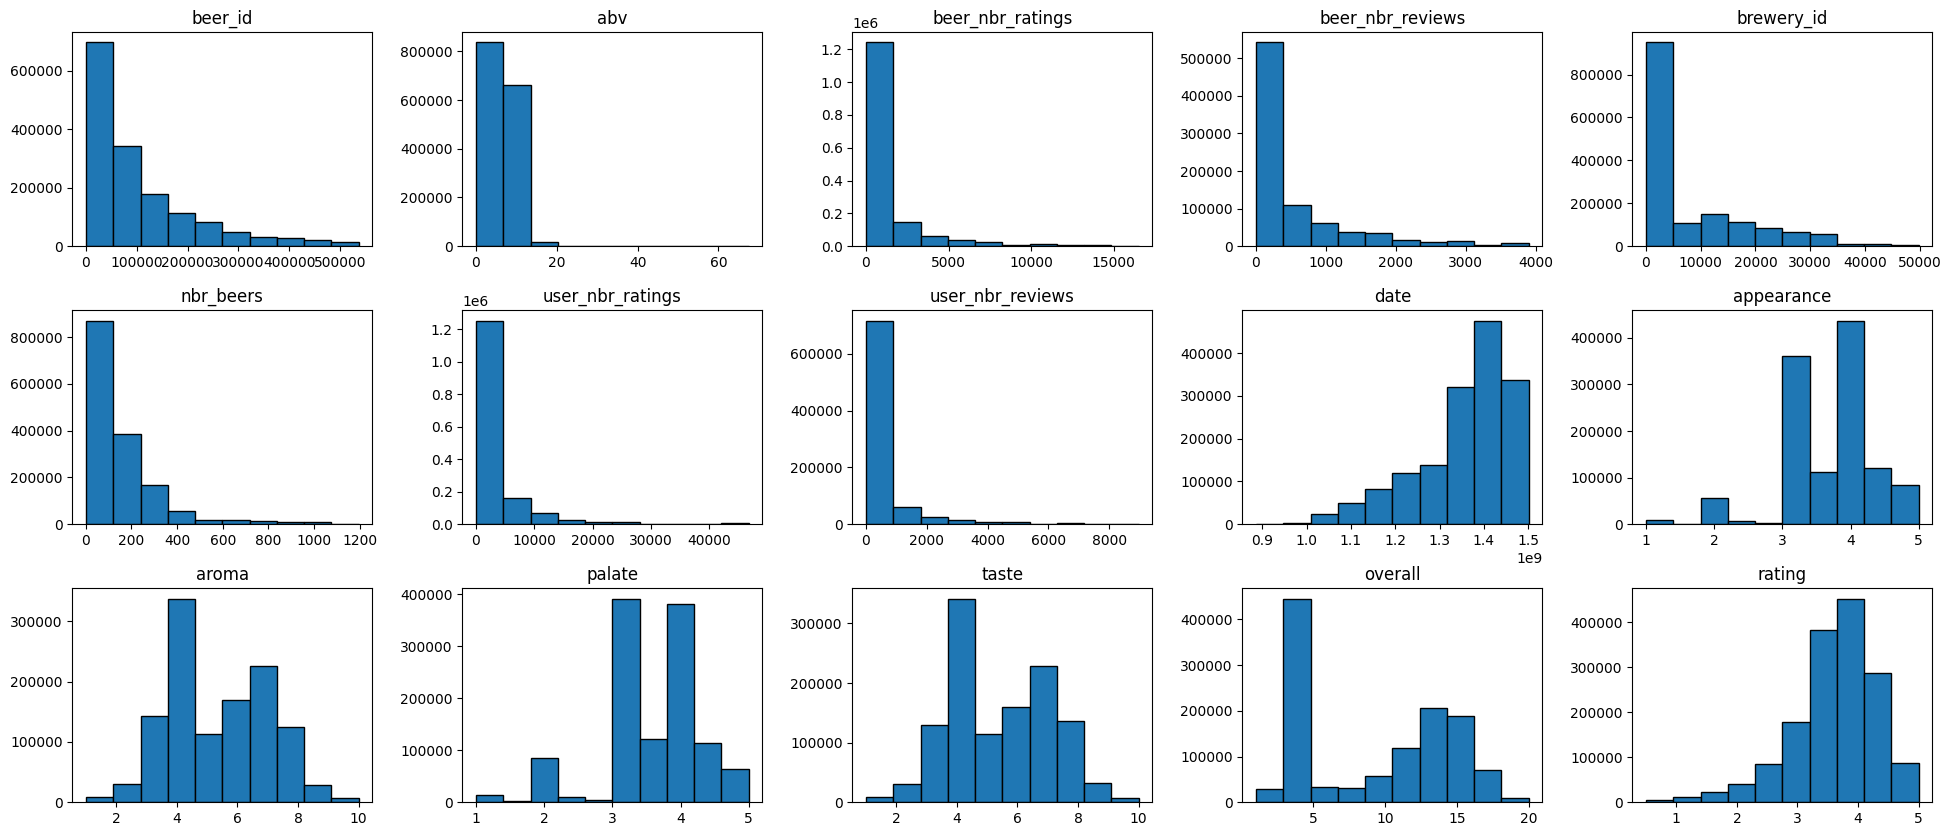

In [7]:
fig, axis = plt.subplots(3, 5, figsize=(24,10));
ratings_mixed_sample.hist(ax=axis, edgecolor='black', grid=False)
# TODO remove printed array (IDK how to do it yet)

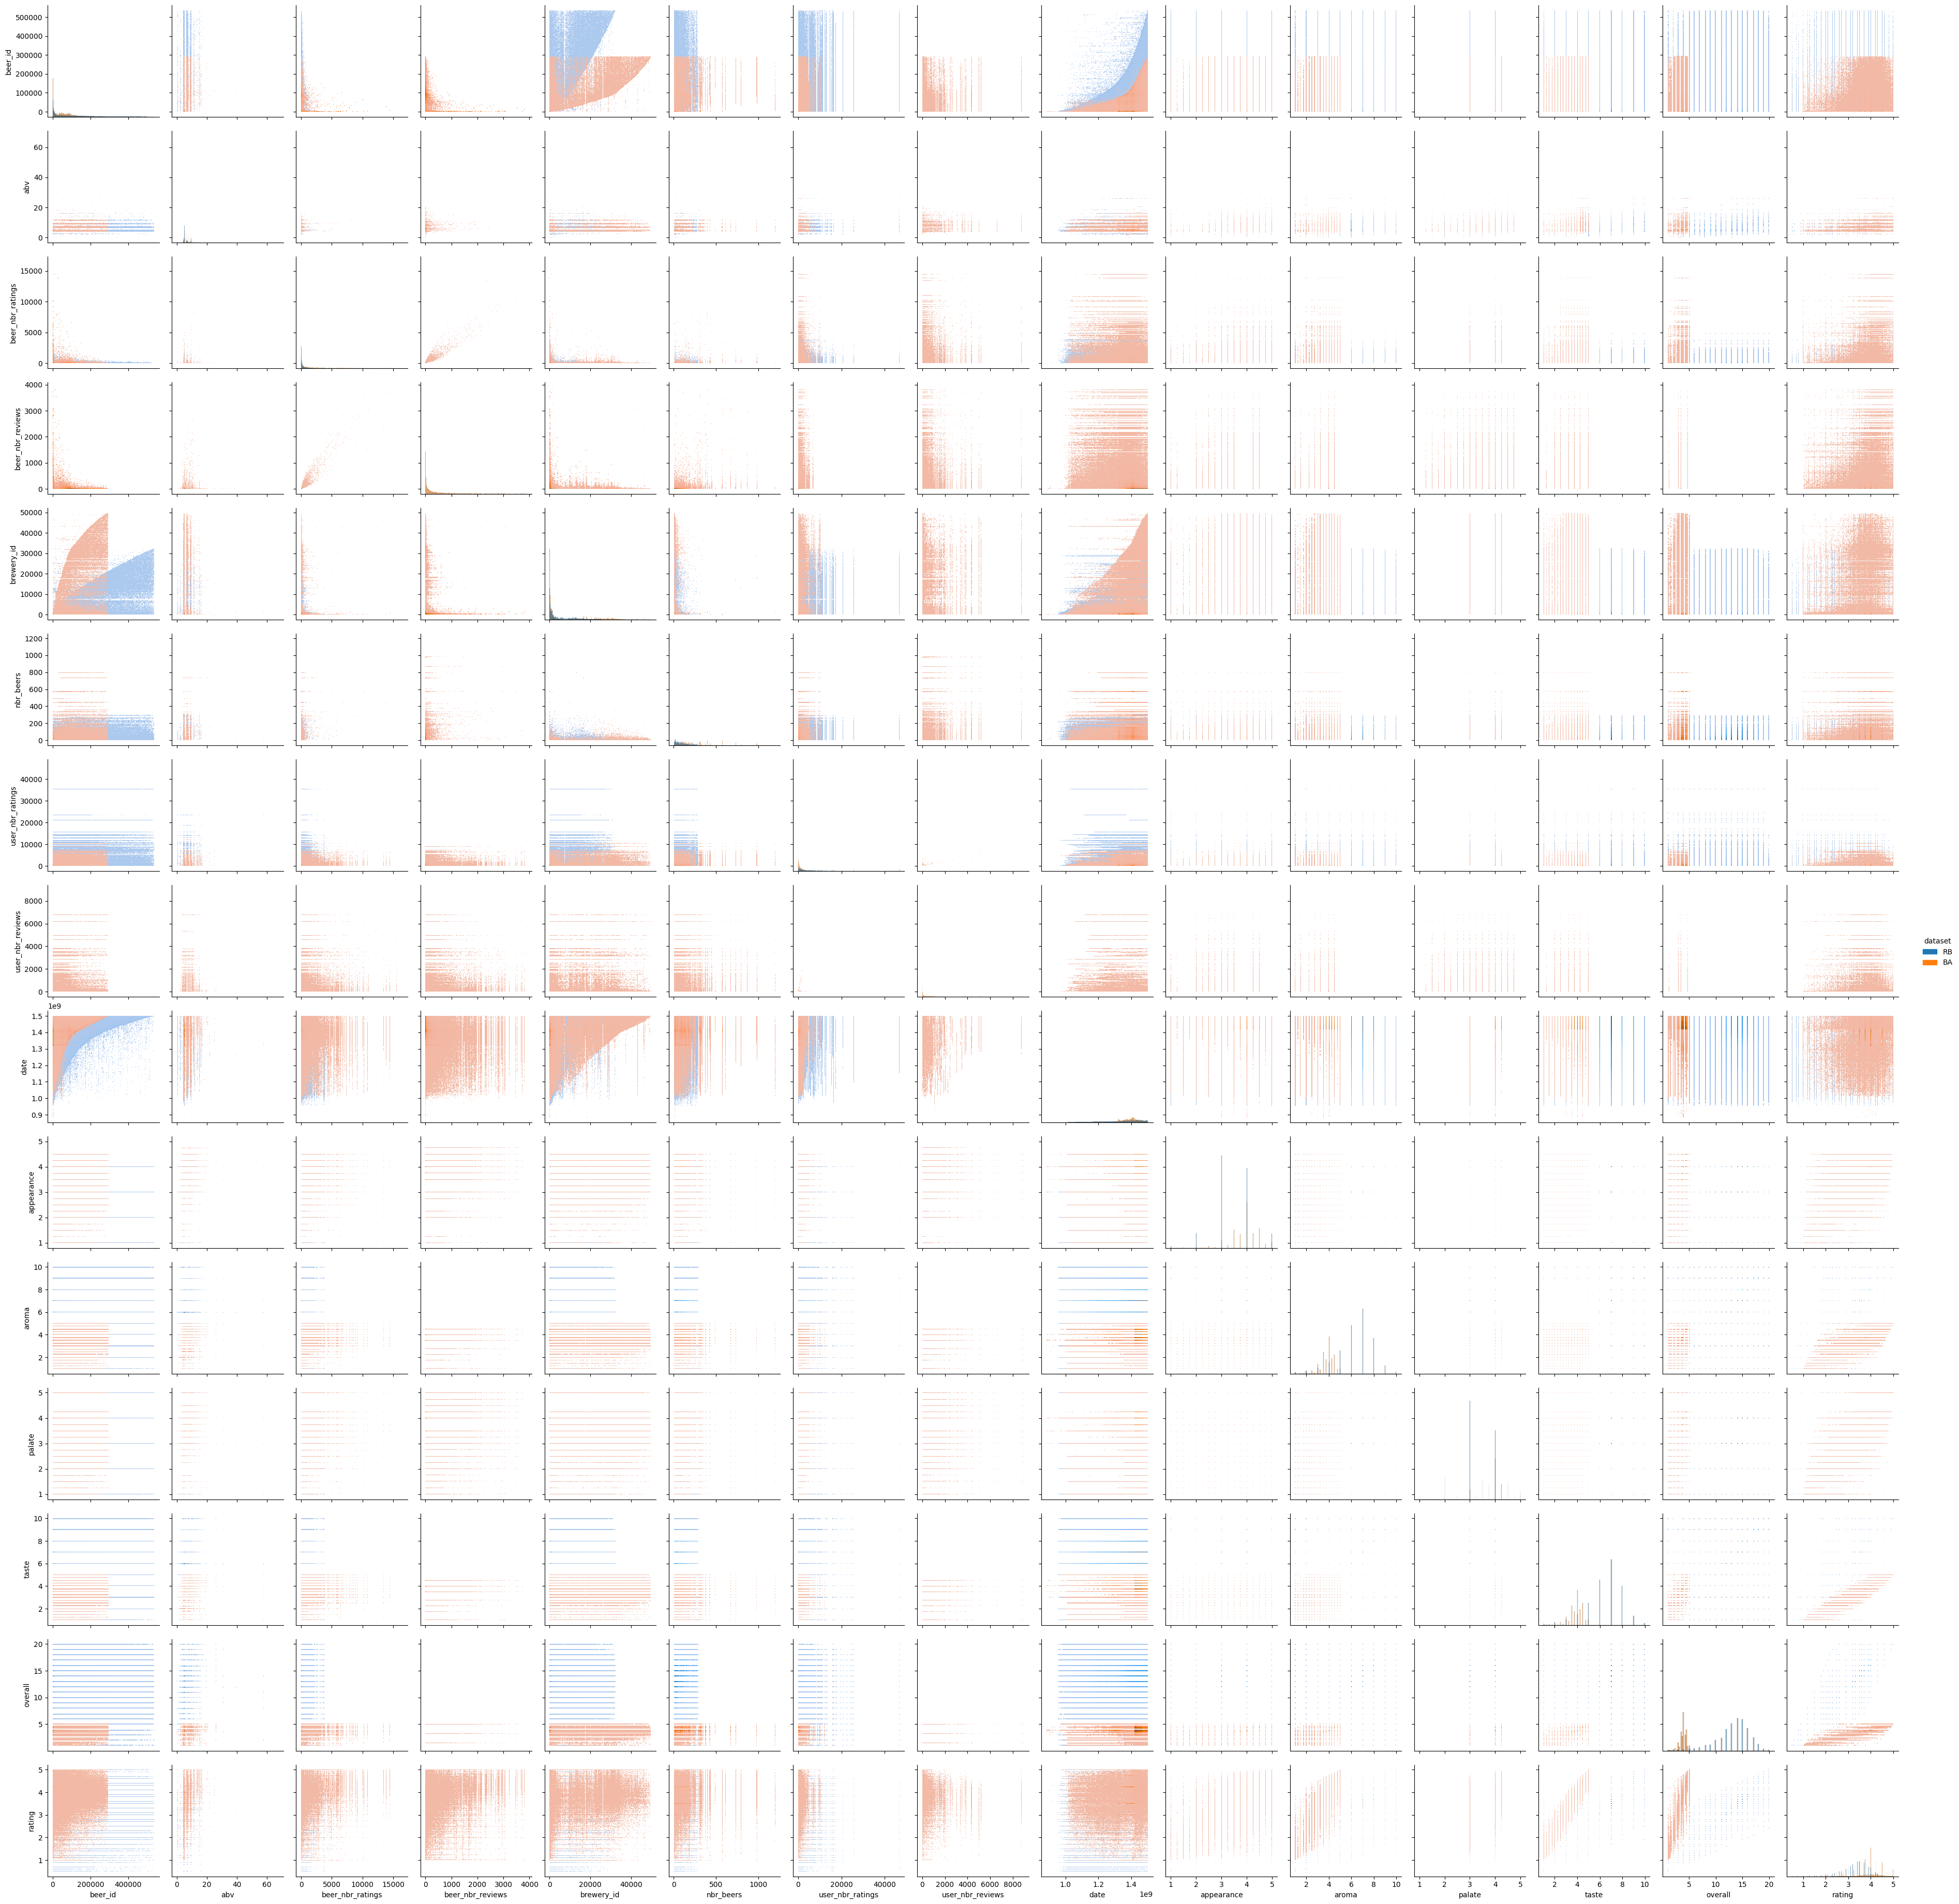

In [5]:
sns.pairplot(ratings_mixed_sample, hue="dataset", kind='hist')

## Have an overlook of geographic distribution of users and brews

In [ ]:
geolocator = Nominatim(user_agent="geoapiExercises")

def geocode(location):
    try:
        loc = geolocator.geocode(location,language='en')
        if loc:
            location_detail = geolocator.reverse((loc.latitude, loc.longitude), exactly_one=True)
            try:
                address = location_detail.raw['address']
                country = address.get('country', None)
                iso_alpha = address.get('country_code', None).upper()  
                iso_alpha = pycountry.countries.get(alpha_2=iso_alpha.upper()).alpha_3
                return country, iso_alpha
            except:
                return None, None
        else:
            return None, None
    except:
        return None, None


In [ ]:
# For user locations
user_unique=ratings_mixed_sample.drop_duplicates(subset='user_id', keep='first')  # Keep only one row per user
user_location_counts = user_unique["user_location"].value_counts()

user_location_counts_df = user_location_counts.reset_index()
user_location_counts_df.columns = ['user_location', 'count']


user_location_counts_df['country_data'] = [geocode(location) for location in tqdm(user_location_counts_df['user_location'])]
# Drop any rows where geocoding failed
user_location_counts_df = user_location_counts_df.dropna(subset=['country_data'])
user_location_counts_df[['country', 'iso_alpha']] = pd.DataFrame(user_location_counts_df['country_data'].tolist(), index=user_location_counts_df.index)
user_country_counts = user_location_counts_df.groupby(['country', 'iso_alpha'])['count'].sum().reset_index()

In [ ]:
# For brew locations
brew_unique=ratings_mixed_sample.drop_duplicates(subset='brewery_id', keep='first')  # Keep only one row per user
brew_location_counts = brew_unique["brewery_location"].value_counts()

brew_location_counts_df = brew_location_counts.reset_index()
brew_location_counts_df.columns = ['brew_location', 'count']


brew_location_counts_df['country_data'] = [geocode(location) for location in tqdm(brew_location_counts_df['brew_location'])]
# Drop any rows where geocoding failed
brew_location_counts_df = brew_location_counts_df.dropna(subset=['country_data'])
brew_location_counts_df[['country', 'iso_alpha']] = pd.DataFrame(brew_location_counts_df['country_data'].tolist(), index=brew_location_counts_df.index)
brew_country_counts = brew_location_counts_df.groupby(['country', 'iso_alpha'])['count'].sum().reset_index()

In [ ]:
# User Map
fig = px.choropleth(user_country_counts,
                    locations="iso_alpha",
                    color="count",
                    hover_name="country",
                    color_continuous_scale=[
                        (0.0, 'rgb(255, 255, 229)'),  
                        (0.01, 'rgb(255, 247, 188)'),  
                        (0.02, 'rgb(254, 227, 145)'), 
                        (0.03, 'rgb(254, 196, 79)'),   
                        (0.04, 'rgb(254, 153, 41)'),  
                        (0.05, 'rgb(236, 112, 20)'),   
                        (0.1, 'rgb(204, 76, 2)'),    
                        (0.5, 'rgb(153, 52, 4)'),     
                        (1.0, 'rgb(102, 37, 6)'),     
                    ],
                    projection="natural earth")
fig.update_layout(title_text='World Map of User Locations', title_x=0.5, title_font_size=30)
fig.show()

In [ ]:
fig = px.choropleth(brew_country_counts,
                    locations="iso_alpha",
                    color="count",
                    hover_name="country",
                    color_continuous_scale=[
                        (0.0, 'rgb(255, 255, 229)'),  
                        (0.01, 'rgb(255, 247, 188)'),  
                        (0.02, 'rgb(254, 227, 145)'), 
                        (0.03, 'rgb(254, 196, 79)'),   
                        (0.04, 'rgb(254, 153, 41)'),  
                        (0.05, 'rgb(236, 112, 20)'),   
                        (0.1, 'rgb(204, 76, 2)'),    
                        (0.5, 'rgb(153, 52, 4)'),     
                        (1.0, 'rgb(102, 37, 6)'),     
                    ],
                    projection="natural earth")
fig.update_layout(title_text='World Map of Brewery Locations', title_x=0.5, title_font_size=30)
fig.show()

An interesting finding is that in sampled data we don't have so many German users but for Breweries, we have a lot!

## Analysis

### Linear regression on subset of reviews
Function that takes a subset of ratings and columns of interest as input and returns a Linear Regresion results

In [ ]:
def get_LR(data, columns):
    data_to_process = data.copy() # copy original dataset
    
    # create formula
    columns=list(columns)
    formula = 'rating ~ ' + columns[0]
    for el in columns[1:-1]:
        formula += ' + ' + el
    
    # standardization and creation of the formula
    columns.append('rating')  # add rating for the linear regression and standardization
    data_to_process = data_to_process[columns].dropna().sample(frac=1)  # only keeps columns of interest and shuffle the samples
    data_to_process = (data_to_process - data_to_process.mean()) / data_to_process.std()
    
    # create the model and fit it to the dataset
    mod = smf.ols(formula=formula, data=data_to_process)
    np.random.seed(2)
    res = mod.fit()
    return res

### Linear regression on the full set

In [ ]:
print('Initial columns:\n', ratings_mixed_sample.columns)
columns_of_interest = ["appearance",  "aroma",  "palate",  "taste",  "overall"]
print('\n==============\n')
print('Chosen columns for linear regression are :\n', columns_of_interest)
res = get_LR(ratings_mixed_sample, columns_of_interest)

print('\n==============\n')
print('Results of the linear regression:\n')
print(res.summary())

In [ ]:
print('Let\' now sort the coefficients by absolute impact on the rating:')
print(pd.DataFrame(res.params).sort_values(0, ascending=False, key=abs).to_string(index=True, header=False))

### Results
From what we can see of this preliminary analysis, some features are having almost 3 times the influence of others on the rating.
Moreover, the R-squared of the fitted model is **0.796** which means that the regression explains roughly 80% of the variation in the variables which is indicating that this simple model alreay fit quite well the data. In the future of this project, we plan to try more complex architectures in order to get the most accurate representation of the impact of each variable.

Let now see if this influence stays constant geographically..

## Params statistics user_location-wise

In [ ]:
# Keep only reviews where user_location has at least 1000 reviews (Arbitrary)
ratings_mixed_1000 = ratings_mixed_sample[ratings_mixed_sample.groupby('user_location')['user_location'].transform('size') > 1000]
countries = ratings_mixed_1000.user_location.unique()
param_df = res.params.copy()

# Analysis of LR parameters among countries
for country in countries:
    country_df = ratings_mixed_1000.loc[ratings_mixed_1000['user_location']==country]
    res = get_LR(country_df, columns_of_interest)
    param_df = pd.concat((param_df, res.params.copy()), axis=1)

# Params per country
param_df.T.describe()

### Number of review per day using rolling average

In [ ]:

# Assuming the file is named 'beer_ratings.csv' and is located in the same directory as your script.
# Read the CSV file
MD_NR_RW_DAY=ratings_mixed_sample
# Convert the Unix time to a datetime object, assuming the 'date' column is Unix time in seconds
MD_NR_RW_DAY['date'] = pd.to_datetime(MD_NR_RW_DAY['date'], unit='s')

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later
MD_NR_RW_DAY_WW = MD_NR_RW_DAY[(MD_NR_RW_DAY['date'] >= start_date) & (MD_NR_RW_DAY['date'] <= end_date)]


In [ ]:
# Group by the date and count the reviews
def plot_rolling(df, window=7):
    daily_reviews = df.groupby(df['date'].dt.date).size()
    # Calculate the moving average with a window size of 7 to remove weeks days
    rolling = daily_reviews.rolling(window=window, center=True)
    rolling_average = rolling.mean()
    
    # Plot the rolling average
    plt.figure(figsize=(14, 7))
    rolling_average.plot(title=f"Number of Reviews Per Day Over One Year with rolling window of {window} days")
    
    # Add labels and grid
    plt.xlabel('Date')
    plt.ylabel('Number of Reviews')
    plt.grid(True)
    plt.show()
plot_rolling(MD_NR_RW_DAY_WW)

### Limiting to german beers

In [ ]:
german_beers= ratings_mixed_sample[ratings_mixed_sample["brewery_location"]=='Germany'].copy()
german_beers['date'] = pd.to_datetime(german_beers['date'], unit='s')

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later

german_beers_WW = german_beers[(german_beers['date'] >= start_date) & (german_beers['date'] <= end_date)]
plot_rolling(german_beers_WW)

### Limiting to german beers and users

In [ ]:
german_users= ratings_mixed_sample[(ratings_mixed_sample["brewery_location"]=='Germany') & (ratings_mixed_sample["user_location"]=='Germany')].copy()

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later

german_users_WW = german_users[(german_users['date'] >= start_date) & (german_users['date'] <= end_date)]
plot_rolling(german_users_WW, 7)

### Alcohol by volume evolution in a mean year by country of user

In [ ]:
alcohol_reviews = ratings_mixed_sample[['date','user_location','abv']]
alcohol_reviews = alcohol_reviews.dropna()

alcohol_reviews.loc[:,'date'] = alcohol_reviews[['date']].apply(lambda x: pd.to_datetime(x, unit='s'))
alcohol_reviews.loc[:,'time'] = alcohol_reviews.loc[:,'date'].apply(lambda x: x.year)
alcohol_reviews = alcohol_reviews.drop(columns = "date")
alcohol_reviews = alcohol_reviews[alcohol_reviews.groupby('user_location')['user_location'].transform('size') > 50000]
alcohol_reviews

In [ ]:
mean_abv = alcohol_reviews.groupby(["user_location", "time"]).var().reset_index()

# Create a plot with multiple lines and legend
plt.figure(figsize=(10, 6))

for location in mean_abv["user_location"].unique():
    location_data = mean_abv[mean_abv["user_location"] == location]
    plt.plot(location_data["time"], location_data["abv"], label=location)

plt.xlabel("Time")
plt.ylabel("ABV")
plt.ylim([0, 15])
plt.legend(loc="upper right")
plt.title("ABV vs Time for Different User Locations")
plt.grid(True)
plt.show()

In [ ]:
mean_abv = alcohol_reviews.groupby(["user_location", "time"]).var().reset_index()
mean_abv.groupby("user_location").plot(x="time", y='abv', kind='line', ylim=[0, 15], subplots=True, sharex=False, sharey=True, layout= (1, -1), stacked=True, use_index=True)

In [ ]:
alcohol_reviews_global = alcohol_reviews.drop(columns='user_location')
mean_abv = alcohol_reviews_global.groupby(["time"]).var().reset_index()
mean_abv.plot(x="time", y='abv', kind='line', ylim=[0, 15])

In [ ]:
mean_abv = alcohol_reviews.groupby(["time"]).median().reset_index()
mean_abv.plot(x="time", y='abv', kind='line', ylim=[0, 15] )

In [ ]:
mean_abv = alcohol_reviews.groupby(["time"]).std().reset_index()
mean_abv.plot(x="time", y='abv', kind='line', ylim=[0, 15] )

### Test of Bens idea 2.2

In [ ]:
# Assuming you have pandas DataFrames: ratings_BA, breweries_BA

# 1. Calculate average ratings per brewery in ratings_BA
avg_ratings = ratings_BA.groupby('brewery_id')['rating'].mean().reset_index()
avg_ratings.rename(columns={'rating': 'average_rating'}, inplace=True)

# 2. Rename columns in breweries_BA and filter out breweries with more than 200 beers
breweries_BA.rename(columns={'id': 'brewery_id', 'nbr_beers': 'beer_count'}, inplace=True)
filtered_breweries = breweries_BA[breweries_BA['beer_count'] <= 200]

# 3. Analysis: Merge the dataframes for plotting
analysis_df = pd.merge(avg_ratings, filtered_breweries[['brewery_id', 'beer_count']], on='brewery_id')

# Create a line plot with a 95% confidence interval
sns.lineplot(data=analysis_df, x='beer_count', y='average_rating', errorbar=('ci', 95))

plt.xlabel('Number of Beers Produced (up to 200)')
plt.ylabel('Average Rating')
plt.title('Relationship between Number of Beers and Average Ratings')
plt.show()


## Reviews and Trustworthiness of Users

In [ ]:
print(ratings_mixed_sample.shape)
print(ratings_mixed_sample["user_id"].nunique())

Very likely that the same user has rated multiple beers

In [ ]:
ratings_mixed_sample["text"] = ratings_mixed_sample['text'].astype(str)
user_review={}
grouped = ratings_mixed_sample.groupby("user_id")

for user, group in tqdm(grouped, total=grouped.ngroups):
    number = group.shape[0]
    average_rating = group["rating"].mean()
    average_review_length = group["text"].str.len().mean()

    user_review[user] = [number, average_rating, average_review_length]


sorted_user_review = sorted(user_review.items(), key=lambda item: item[1][0], reverse=True)  
# if your python version is < 3.7, please notice that the dictionary is not ordered
user_review = {user: values for user, values in sorted_user_review}

In [ ]:
number_review = [user_review[user][0] for user in user_review]  # Number of Reviews
avg_review_len = [user_review[user][2] for user in user_review]  # Average Review Length
avg_rating=[user_review[user][1] for user in user_review] # Average Rating

fig,axs=plt.subplots(1,2,figsize=(10,5))
plt.tight_layout()

axs[0].scatter(number_review, avg_review_len, label='Data Points')
axs[0].set_xlabel('Number of Reviews')
axs[0].set_ylabel('Average Review Length')
axs[0].set_title('Average Review Length vs Number of Reviews')
axs[1].scatter(number_review, avg_rating, label='Data Points')
axs[1].set_xlabel('Number of Reviews')
axs[1].set_ylabel('Average Rating')
axs[1].set_title('Average Rating vs Number of Reviews')

Then, what we should do in the future is how to give a "trust" score to a user based on the analysis of his/her data